In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import consensus_score
from sklearn.cluster.bicluster import SpectralCoclustering

import csv

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and show data

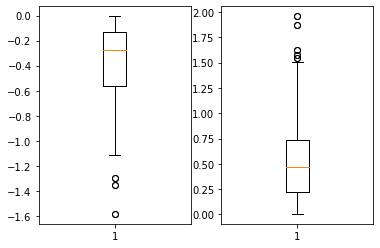

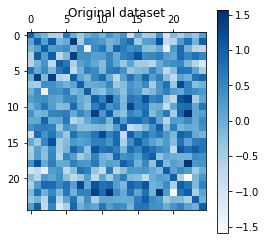

In [2]:
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

N = len(ISC_EEG)

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMAgnitude(matrix):
    for i in range(N):
        matrix[i,i] = 0
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)
    
# Remove outlier if we find one
def removeOutlierArray(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    with open(os.path.join('ISC_truncated.csv'), 'w') as File:
        writer = csv.writer(File)
        writer.writerows(matrix)
    
    return new_mat

def removeOutlierVector(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    return new_mat
    
orderOfMAgnitude(np.copy(ISC_EDA))
    
# Remove Inf in data
for i in range(N):
    ISC_IBI[i,i] = 1
    ISC_EDA[i,i] = 1
    
ISC_EDA = removeOutlierArray(ISC_EDA,12)

matrix = ISC_EDA    

plt.matshow(matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

In [3]:
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array

condition = removeOutlierVector(condition,12)

narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]

In [4]:
# Transform matrix into correlation matrix
#if ((matrix == ISC_EEG).all()):
if (False):
    matrix_norm = np.copy(matrix) / 3
    matrix_cheat = np.copy(matrix)
    for i in range(len(matrix)):
        matrix_cheat[i,i] = 0.05
else:
    matrix_norm = np.copy(matrix)
    for i in range(len(matrix)):
        matrix_norm[i,i] = 1

# Normalise max value to 1
matrix_norm = matrix_norm / np.max(abs(matrix_norm))
        
# Compute distance matrix
matrix_dist = np.sqrt(2*N*(1-matrix_norm))

'''
# Normalise data
for i in range(len(matrix)):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
''' 

'\n# Normalise data\nfor i in range(len(matrix)):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

## Bloc modelling / Bi-clustering

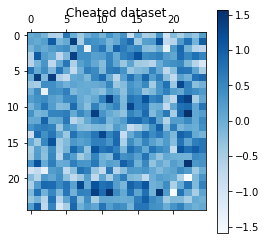

In [5]:
matrix_cheat = np.copy(matrix)
for i in range(len(matrix)):
    matrix_cheat[i,i] = 0.05
        
plt.matshow(matrix_cheat, cmap=plt.cm.Blues)
plt.title("Cheated dataset")
plt.colorbar()
plt.show()

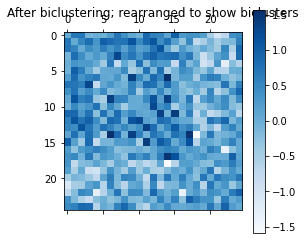

In [6]:
model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(matrix_cheat)
#score = consensus_score(model.biclusters_,
#                        (rows[:, row_idx], columns[:, col_idx]))

#print("consensus score: {:.3f}".format(score))

fit_data = matrix_cheat[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

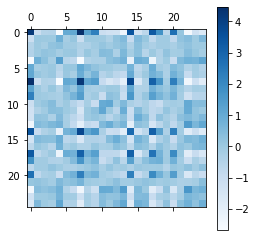

In [7]:
decorr = np.linalg.inv(matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Hierarchical clustering

### Hierarchical clustering based on correlation (cheating on the diagonal)

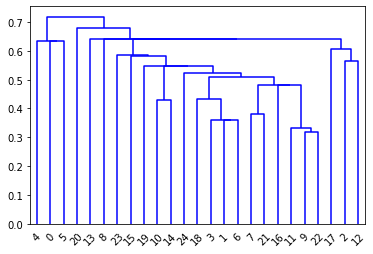

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

for i in range(len(matrix)):
    matrix_cheat[i,i] = 3
    
matrix_norm = matrix_cheat / 3
Z=linkage(matrix_norm, 'single', 'correlation')
dendrogram(Z, color_threshold=0)
plt.show()

### Hierarchical clustering based on euclidean distance

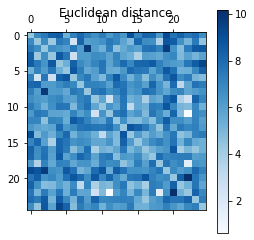

In [9]:
plt.matshow(matrix_dist, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

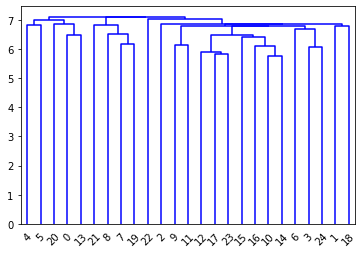

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(matrix_dist, 'single', 'euclidean')
dendrogram(Z, color_threshold=0)
plt.show()

In [11]:
print("group 0 : ",narrative)
print("group 1 : ",stimulus)

group 0 :  [ 0  2  4  5  7  9 11 12 15 16 17 21 24]
group 1 :  [ 1  3  6  8 10 13 14 18 19 20 22 23]


In [12]:
"""
Multi-dimensional Scaling (MDS)
"""

# author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
# License: BSD

import numpy as np

import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.externals.joblib import Parallel
from sklearn.externals.joblib import delayed
from sklearn.isotonic import IsotonicRegression


def _smacof_single(dissimilarities, metric=True, n_components=2, init=None,
                   max_iter=300, verbose=0, eps=1e-3, random_state=None,
                   normalize=False):
    """Computes multidimensional scaling using SMACOF algorithm
    Parameters
    ----------
    dissimilarities : ndarray, shape (n_samples, n_samples)
        Pairwise dissimilarities between the points. Must be symmetric.
    metric : boolean, optional, default: True
        Compute metric or nonmetric SMACOF algorithm.
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities. If an
        ``init`` array is provided, this option is overridden and the shape of
        ``init`` is used to determine the dimensionality of the embedding
        space.
    init : ndarray, shape (n_samples, n_components), optional, default: None
        Starting configuration of the embedding to initialize the algorithm. By
        default, the algorithm is initialized with a randomly chosen array.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Returns
    -------
    X : ndarray, shape (n_samples, n_components)
        Coordinates of the points in a ``n_components``-space.
    stress : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    n_iter : int
        The number of iterations corresponding to the best stress.
    """
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)

    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    if init is None:
        # Randomly choose initial configuration
        X = random_state.rand(n_samples * n_components)
        X = X.reshape((n_samples, n_components))
    else:
        # overrides the parameter p
        n_components = init.shape[1]
        if n_samples != init.shape[0]:
            raise ValueError("init matrix should be of shape (%d, %d)" %
                             (n_samples, n_components))
        X = init

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)

        if metric:
            disparities = dissimilarities
        else:
            dis_flat = dis.ravel()
            # dissimilarities with 0 are considered as missing values
            dis_flat_w = dis_flat[sim_flat != 0]

            # Compute the disparities using a monotonic regression
            disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
            disparities = dis_flat.copy()
            disparities[sim_flat != 0] = disparities_flat
            disparities = disparities.reshape((n_samples, n_samples))
            disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) /
                                   (disparities ** 2).sum())

        # Compute raw stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Use Stress-1
        if normalize:
            stress = np.sqrt(stress /
                             ((disparities.ravel() ** 2).sum() / 2))

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose >= 2:
            print('it: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('breaking at iteration %d with stress %s' % (it,
                                                                       stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def smacof(dissimilarities, metric=True, n_components=2, init=None, n_init=8,
           n_jobs=1, max_iter=300, verbose=0, eps=1e-3, random_state=None,
           return_n_iter=False, normalize=False):
    """Computes multidimensional scaling using the SMACOF algorithm.
    The SMACOF (Scaling by MAjorizing a COmplicated Function) algorithm is a
    multidimensional scaling algorithm which minimizes an objective function
    (the *stress*) using a majorization technique. Stress majorization, also
    known as the Guttman Transform, guarantees a monotone convergence of
    stress, and is more powerful than traditional techniques such as gradient
    descent.
    The SMACOF algorithm for metric MDS can summarized by the following steps:
    1. Set an initial start configuration, randomly or not.
    2. Compute the stress
    3. Compute the Guttman Transform
    4. Iterate 2 and 3 until convergence.
    The nonmetric algorithm adds a monotonic regression step before computing
    the stress.
    Parameters
    ----------
    dissimilarities : ndarray, shape (n_samples, n_samples)
        Pairwise dissimilarities between the points. Must be symmetric.
    metric : boolean, optional, default: True
        Compute metric or nonmetric SMACOF algorithm.
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities. If an
        ``init`` array is provided, this option is overridden and the shape of
        ``init`` is used to determine the dimensionality of the embedding
        space.
    init : ndarray, shape (n_samples, n_components), optional, default: None
        Starting configuration of the embedding to initialize the algorithm. By
        default, the algorithm is initialized with a randomly chosen array.
    n_init : int, optional, default: 8
        Number of times the SMACOF algorithm will be run with different
        initializations. The final results will be the best output of the runs,
        determined by the run with the smallest final stress. If ``init`` is
        provided, this option is overridden and a single run is performed.
    n_jobs : int, optional, default: 1
        The number of jobs to use for the computation. If multiple
        initializations are used (``n_init``), each run of the algorithm is
        computed in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For ``n_jobs`` below -1,
        (``n_cpus + 1 + n_jobs``) are used. Thus for ``n_jobs = -2``, all CPUs
        but one are used.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    return_n_iter : bool, optional, default: False
        Whether or not to return the number of iterations.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Returns
    -------
    X : ndarray, shape (n_samples, n_components)
        Coordinates of the points in a ``n_components``-space.
    stress : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    n_iter : int
        The number of iterations corresponding to the best stress. Returned
        only if ``return_n_iter`` is set to ``True``.
    Notes
    -----
    "Modern Multidimensional Scaling - Theory and Applications" Borg, I.;
    Groenen P. Springer Series in Statistics (1997)
    "Nonmetric multidimensional scaling: a numerical method" Kruskal, J.
    Psychometrika, 29 (1964)
    "Multidimensional scaling by optimizing goodness of fit to a nonmetric
    hypothesis" Kruskal, J. Psychometrika, 29, (1964)
    """

    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    if hasattr(init, '__array__'):
        init = np.asarray(init).copy()
        if not n_init == 1:
            warnings.warn(
                'Explicit initial positions passed: '
                'performing only one init of the MDS instead of %d'
                % n_init)
            n_init = 1

    best_pos, best_stress = None, None

    if n_jobs == 1:
        for it in range(n_init):
            pos, stress, n_iter_ = _smacof_single(
                dissimilarities, metric=metric,
                n_components=n_components, init=init,
                max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state,
                normalize=normalize)
            if best_stress is None or stress < best_stress:
                best_stress = stress
                best_pos = pos.copy()
                best_iter = n_iter_
    else:
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=max(verbose - 1, 0))(
            delayed(_smacof_single)(
                dissimilarities, metric=metric, n_components=n_components,
                init=init, max_iter=max_iter, verbose=verbose, eps=eps,
                random_state=seed, normalize=normalize)
            for seed in seeds)
        positions, stress, n_iters = zip(*results)
        best = np.argmin(stress)
        best_stress = stress[best]
        best_pos = positions[best]
        best_iter = n_iters[best]

    if return_n_iter:
        return best_pos, best_stress, best_iter
    else:
        return best_pos, best_stress


class MDS(BaseEstimator):
    """Multidimensional scaling
    Read more in the :ref:`User Guide <multidimensional_scaling>`.
    Parameters
    ----------
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities.
    metric : boolean, optional, default: True
        If ``True``, perform metric MDS; otherwise, perform nonmetric MDS.
    n_init : int, optional, default: 4
        Number of times the SMACOF algorithm will be run with different
        initializations. The final results will be the best output of the runs,
        determined by the run with the smallest final stress.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    n_jobs : int, optional, default: 1
        The number of jobs to use for the computation. If multiple
        initializations are used (``n_init``), each run of the algorithm is
        computed in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For ``n_jobs`` below -1,
        (``n_cpus + 1 + n_jobs``) are used. Thus for ``n_jobs = -2``, all CPUs
        but one are used.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    dissimilarity : 'euclidean' | 'precomputed', optional, default: 'euclidean'
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities are passed directly to ``fit`` and
            ``fit_transform``.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Attributes
    ----------
    embedding_ : array-like, shape (n_components, n_samples)
        Stores the position of the dataset in the embedding space.
    stress_ : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    References
    ----------
    "Modern Multidimensional Scaling - Theory and Applications" Borg, I.;
    Groenen P. Springer Series in Statistics (1997)
    "Nonmetric multidimensional scaling: a numerical method" Kruskal, J.
    Psychometrika, 29 (1964)
    "Multidimensional scaling by optimizing goodness of fit to a nonmetric
    hypothesis" Kruskal, J. Psychometrika, 29, (1964)
    """
    def __init__(self, n_components=2, metric=True, n_init=4,
                 max_iter=300, verbose=0, eps=1e-3, n_jobs=1,
                 random_state=None, dissimilarity="euclidean",normalize = False):
        self.n_components = n_components
        self.dissimilarity = dissimilarity
        self.metric = metric
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.normalize = normalize

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def fit(self, X, y=None, init=None):
        """
        Computes the position of the points in the embedding space
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        y: Ignored
        init : ndarray, shape (n_samples,), optional, default: None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, y=None, init=None):
        """
        Fit the data from X, and returns the embedded coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        y: Ignored
        init : ndarray, shape (n_samples,), optional, default: None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.
        """
        X = check_array(X)
        if X.shape[0] == X.shape[1] and self.dissimilarity != "precomputed":
            warnings.warn("The MDS API has changed. ``fit`` now constructs an"
                          " dissimilarity matrix from data. To use a custom "
                          "dissimilarity matrix, set "
                          "``dissimilarity='precomputed'``.")

        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix_ = euclidean_distances(X)
        else:
            raise ValueError("Proximity must be 'precomputed' or 'euclidean'."
                             " Got %s instead" % str(self.dissimilarity))

        self.embedding_, self.stress_, self.n_iter_ = smacof(
            self.dissimilarity_matrix_, metric=self.metric,
            n_components=self.n_components, init=init, n_init=self.n_init,
            n_jobs=self.n_jobs, max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state,
            return_n_iter=True,normalize=self.normalize)

        return self.embedding_

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Multi Dimensionnal Scaling

In [13]:
#from sklearn import manifold

def computeMDSCoordinate(n_comp,metric=True):
    mds = MDS(n_components=n_comp,random_state=1,normalize=True,eps=1e-10,metric=metric)
    mds.fit(matrix_dist)
    points = mds.embedding_
    stress = mds.stress_
    '''
    Stress-1 that according to Kruskal (1964, p. 3) has more or less 
    the following interpretation: value 0 indicates perfect fit, 
    0.025 excellent, 0.05 good, 0.1 fair and 0.2 poor.
    '''
    print("Stress of the method : %f" %stress)

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    return points, stress

In [14]:
from sklearn import manifold

def mdsScikit(n_comp):
    mds = manifold.MDS(n_components=n_comp,random_state=1)
    mds.fit(matrix_dist)
    points = mds.embedding_
    stress = mds.stress_

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    return points

Stress of the method : 0.550898


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.259594


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.163000


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.078085


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.061484


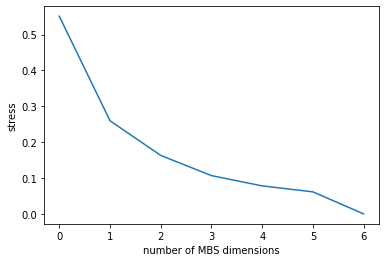

In [15]:
from sklearn.decomposition import PCA

def transformPoints(points):
    pca = PCA(n_components=2)
    points = pca.fit_transform(points)
    print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:2]))
    return points

def plotMdsPoints(points,projection=False):

    ax = plt.axes([1.2,0,1,1])
    ax.set_aspect(aspect='equal')
    if (projection):
        points = transformPoints(points)
    
    for i in range(len(condition)):
        if (condition[i] == 0):
            color = 'blue'
        else:
            color = 'red'
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+0.3,points[i,1]))

    plt.scatter(points[narrative,0],points[narrative,1],color='red',s=150)
    plt.scatter(points[stimulus,0],points[stimulus,1],color='blue',s=150)
    
    plt.title('MDS map')

# Find best MDS dimension
stress = np.zeros((int(N/4)+1,1))
for i in range(1,int(N/4)+1):
    points,stress[i-1] = computeMDSCoordinate(i)

plt.plot(stress)
plt.xlabel("number of MBS dimensions")
plt.ylabel("stress")

mdsDim = 4


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713
0.632279 variance explained when plotting


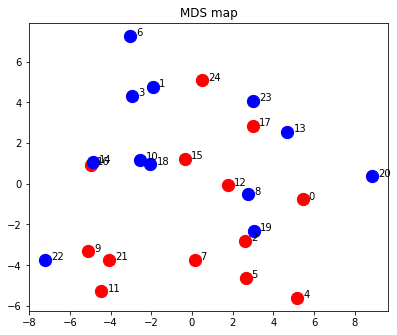

In [19]:
'''
points = mdsScikit(10)
ax = plt.axes([0,0,1,1])
ax.set_aspect(aspect='equal')
plotMdsPoints(points,ax)
'''
#ax = plt.axes([1.2,0,1,1])
#ax.set_aspect(aspect='equal')
#points = computeMDSCoordinate(10)
#plotMdsPoints(points,projection=True)

points,stress = computeMDSCoordinate(mdsDim)
plotMdsPoints(points,projection=True)

## DBSCAN (here for precomputed metric -> array of distances)

In [37]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3,metric='precomputed').fit(matrix_dist)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713
0.632279 variance explained when plotting


ValueError: x and y must have same first dimension, but have shapes (0,) and (25,)

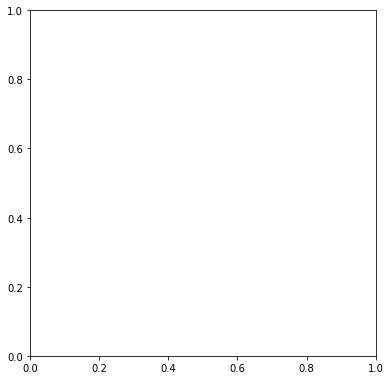

In [38]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
points,stress = computeMDSCoordinate(mdsDim)
points_2D = transformPoints(points)

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

plotMdsPoints(points,projection=True)

## Mean Shift (to do on coordinates)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713
number of estimated clusters : 3
0.632279 variance explained when plotting
1.000000 variance explained when plotting


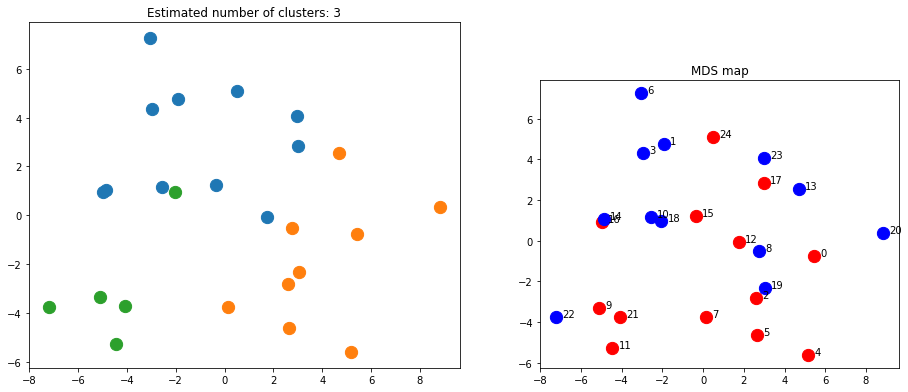

In [39]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
points,stress = computeMDSCoordinate(mdsDim) # Look only at 2 3 or 4D, then bad results

# The following ban*dwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(points[my_members, 0], points[my_members, 1], s=150)
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)

plotMdsPoints(points,projection=True)

plt.show()

## Spectral clustering (on coordinates)

In [44]:
from sklearn.cluster import SpectralClustering

max_prec = 0
dim = 0

for i in range(1,N):
    points,stress = computeMDSCoordinate(i)
    
    #Spectral clustering
    clustering = SpectralClustering(n_clusters=2,
                assign_labels="discretize",
                random_state=0).fit(points)
    if sum(condition==clustering.labels_)/N > max_prec:
        max_prec = sum(condition==clustering.labels_)/N
        label = clustering.labels_
        dim = i
    
print(dim)
print(label)
print(condition)
print(sum(condition==label)/N)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.550898
Stress of the method : 0.259594


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.163000


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.078085


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.061484


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.049400


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.040371


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.034072


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.026186


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.022821


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.017534


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.015597


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.012787


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.009904


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.008574


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.007223


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.006824


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.006152


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.005026


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.004260


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.003515


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.003088


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.002660


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.002723
6
[0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0]
0.6153846153846154


//anaconda3/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:482: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


## K-Means

In [47]:
from sklearn.cluster import KMeans

max_prec = 0
dim = 0

for i in range(1,N):
    points,stress = computeMDSCoordinate(i)
    
    #K-Means
    kmeans = KMeans(n_clusters=2, random_state=0).fit(points)

    if sum(condition==kmeans.labels_)/N > max_prec:
        max_prec = sum(condition==kmeans.labels_)/N
        label = kmeans.labels_
        dim = i
    
print(dim)
print(label)
print(condition)
print(sum(condition==label)/N)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.550898
Stress of the method : 0.259594


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.163000


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.106713


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.078085


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.061484


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.049400


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.040371


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.034072


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.026186


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.022821


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.017534


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.015597


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.012787


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.009904


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.008574


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.007223


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.006824


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.006152


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.005026


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.004260


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.003515


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.003088


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.002660


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


Stress of the method : 0.002723
9
[0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1]
[0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0]
0.5769230769230769
